In [1]:
# Import modules
import os
import datetime
from IPython.display import display
import math
import re


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import scipy
import scipy.stats

In [2]:
# Setup utilities and and data path
datadir = os.path.join('..', 'data')

In [3]:
## Select data to analyze
files = ['isx2008C.xls', 'isx2010C.xls']
filename = os.path.join(datadir, files[1])

# Read all sheets into a dictonary with sheet names as keys
data = pd.read_excel(filename, sheet_name=None)

In [4]:
## Clean data
def clean_sheet(sheet):
    """
    Normalize data and destructure features to respective variables
    
    params:
        sheet (pd.DataFrame):   Excel worksheet
    
    returns:
        sheet (pd.DataFrame):   Modified sheet
        variables:
            mat (pd.Series):    (n,1) Days to maturity
            T (pd.Series):      (n,1) Years to maturity
            S (pd.Series):      (n,1) Stock prices
            Cobs (np.ndarray):  (n,m) Call prices
            E (pd.Series):      (1,m) Strike prices
            r (pd.Series):      (n,1) Risk-free interest rates
    """
    
    # normalize strikes
    strikes = np.array(sheet.columns[1:-3])
    nstrikes = strikes / 1000
    
    sheet['time'] = sheet.mat / 252  # years to maturity
    sheet.s_price /= 1000            # normalize stock prices
    sheet[strikes] /= 1000          # normalize call prices
    sheet.r /= 100                   # risk-free interest rate to percentage
    
    # convert to datetime
    sheet.date = pd.to_datetime(sheet.date)
    
    def replace_outlier(column):
        column[column > 0] /= 1000
        
    # remove call outliers
    sheet[strikes].apply(lambda col: col[col > 1] /1000)
    
    # rename strike columns with normalized strikes
    sheet = sheet.rename(columns={key: key/100 for key in list(strikes)})
    
    # set date as index
    sheet = sheet.set_index(sheet.date)
    
    E = nstrikes             # strike prices
    S = sheet.s_price        # stock prices
    Cobs = sheet.iloc[:, E]  # call prices
    r = sheet.r              # risk-free interest rates
    mat = sheet.mat          # days to maturity
    T = sheet.time           # years to maturity
    
    return sheet, (mat, T, S, Cobs, E, r)

def format_sheet(sheet):
    """
    Rename columns
    """
    return sheet.rename(columns={
        sheet.columns[0]: "mat",
        sheet.columns[-3]: 's_price',
        sheet.columns[-2]: 'r',
        sheet.columns[-1]: 'date'
    })

def get_sheet(data, sheet_name):
    """
    Return cleaned sheet and destructured variables
    """
    sheet = format_sheet(data[sheet_name])
    return clean_sheet(sheet)
    

In [5]:
sheet_names = list(data.keys())
sheet_name = 'isx15012010C'

sheet, (mat, T, S, Cobs, E, r) = get_sheet(data, sheet_name)
n,m = Cobs.shape


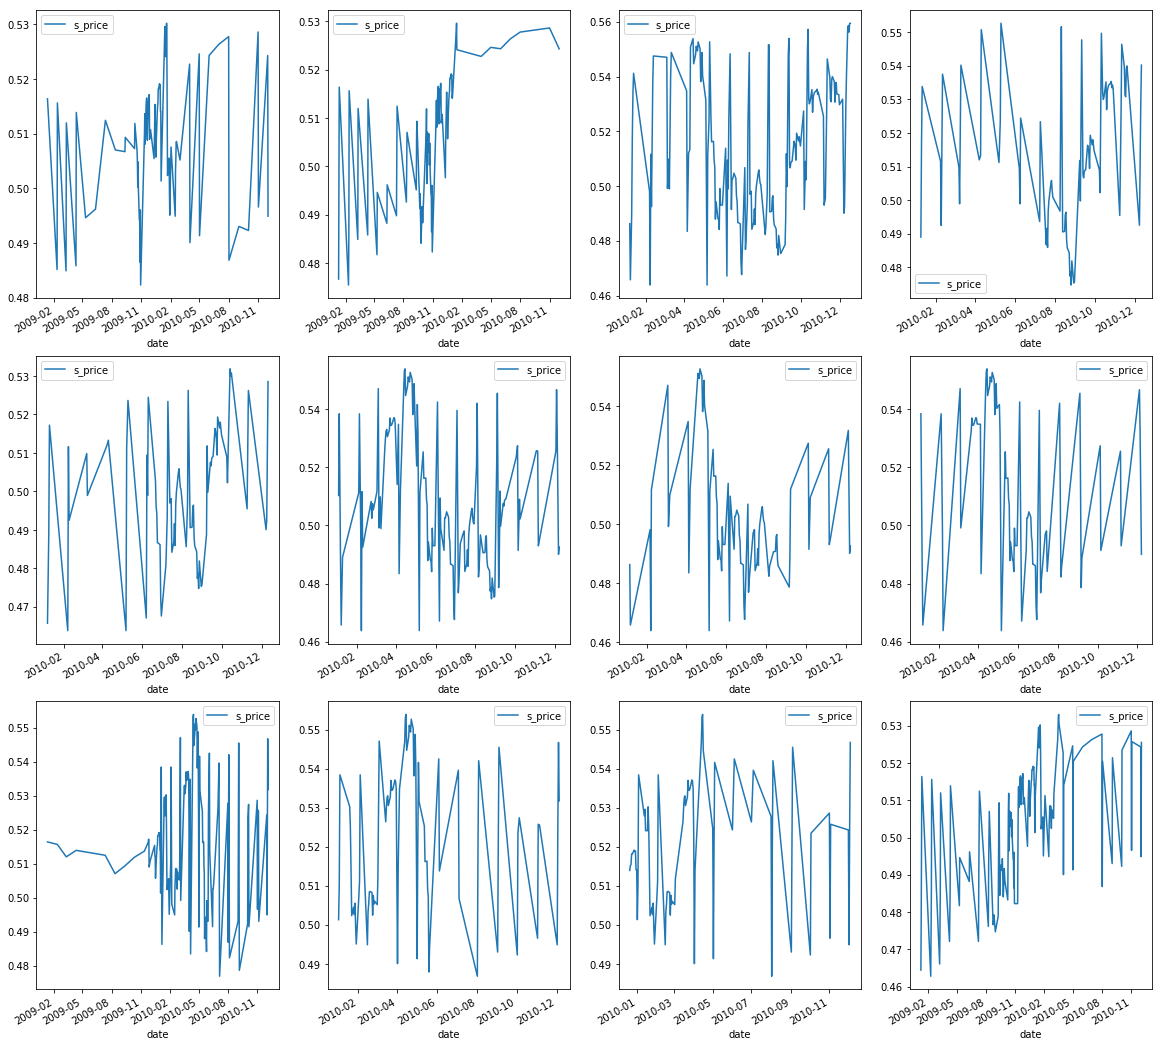

In [7]:
%matplotlib inline

num_sheets = len(sheet_names)
fig, axes = plt.subplots(math.ceil(num_sheets/4), 4, figsize=(20,20))

for name, ax in zip(sheet_names, axes.flat):
    sheet, (mat, T, S, Cobs, E, r) = get_sheet(data, name)
    sheet.plot(y='s_price', ax=ax)
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    

In [13]:
sheet, (mat, T, S, Cobs, E, r) = get_sheet(data, name)
r

date
2009-08-24    0.0017
2009-08-25    0.0017
2009-08-26    0.0017
2009-08-27    0.0017
2009-08-28    0.0016
2009-08-31    0.0016
2009-01-09    0.0016
2009-02-09    0.0016
2009-03-09    0.0016
2009-04-09    0.0014
2009-07-09    0.0014
2009-08-09    0.0014
2009-09-09    0.0014
2009-10-09    0.0014
2009-11-09    0.0014
2009-09-14    0.0014
2009-09-15    0.0014
2009-09-16    0.0014
2009-09-17    0.0014
2009-09-18    0.0011
2009-09-21    0.0011
2009-09-22    0.0011
2009-09-23    0.0011
2009-09-24    0.0011
2009-09-25    0.0011
2009-09-28    0.0011
2009-09-29    0.0011
2009-09-30    0.0011
2009-01-10    0.0011
2009-02-10    0.0012
               ...  
2010-08-02    0.0010
2010-09-02    0.0010
2010-10-02    0.0010
2010-11-02    0.0010
2010-12-02    0.0011
2010-02-15    0.0011
2010-02-16    0.0011
2010-02-17    0.0011
2010-02-18    0.0011
2010-02-19    0.0010
2010-02-22    0.0010
2010-02-23    0.0010
2010-02-24    0.0010
2010-02-25    0.0010
2010-02-26    0.0012
2010-01-03    0.0012
2010-02-